In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from datetime import datetime

pd.set_option("display.width", 80) # default value
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep= ';', low_memory=False)

In [3]:
df.dropna(inplace=True)

In [4]:
df['Global_active_power']=df['Global_active_power'].apply(lambda x:float(x))
df['Global_reactive_power']=df['Global_reactive_power'].apply(lambda x:float(x))
df['Voltage']=df['Voltage'].apply(lambda x:float(x))
df['Global_intensity']=df['Global_intensity'].apply(lambda x:float(x))
df['Sub_metering_1']=df['Sub_metering_1'].apply(lambda x:float(x))
df['Sub_metering_2']=df['Sub_metering_2'].apply(lambda x:float(x))

In [5]:
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
df["date_time"]=pd.to_datetime(df['Date'] + ' ' + df['Time'])

C:\Users\jaros\AppData\Local\Temp\ipykernel_4440\1195730295.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date_time"]=pd.to_datetime(df['Date'] + ' ' + df['Time'])


In [7]:
df['date_time'] = pd.DatetimeIndex(df.date_time) # profilaktycznie

In [8]:
df = df.drop(columns = ['Global_reactive_power', 'Voltage', 'Global_intensity',
                        'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
                        'Date', 'Time'])

In [9]:
df.index = df.date_time

In [10]:
df['ds'] = df.index
df['y'] = df.Global_active_power
df.drop(['date_time','Global_active_power'],axis = 1, inplace = True)

In [11]:
df.head()

,ds,y
date_time,,
2006-12-16 17:24:00,2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,2006-12-16 17:28:00,3.666


In [12]:
df.reset_index(inplace=True)

In [13]:
del df['date_time']

In [14]:
m = Prophet(growth='flat', interval_width=0.95)

In [15]:
m.fit(df)

13:17:23 - cmdstanpy - INFO - Chain [1] start processing
13:18:20 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = m.make_future_dataframe(periods=1440)
future['cap'] = 8.5

In [17]:
fcst = m.predict(future)   #Tu wyskakuje błąd "Unable to allocate 15.3 GiB for an array with shape (1000, 2049280) and data type float64"

In [19]:
from prophet.serialize import model_to_json, model_from_json

with open('model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [ ]:
# with open('serialized_model.json', 'r') as fin:
#     m = model_from_json(fin.read())  # Load model

In [18]:
import pickle

In [20]:
fcst.to_pickle("forecast.pkl")

In [ ]:
# fcast = pd.read_pickle("forecast.pkl")

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

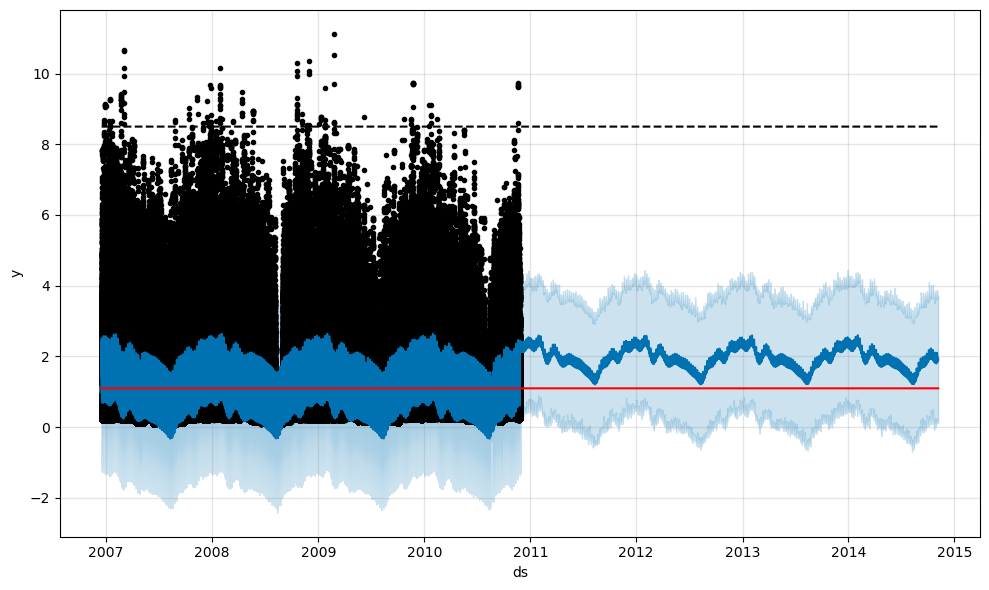

In [30]:
fig = m.plot(fcst)
add_changepoints_to_plot(fig.gca(), m, fcst)
plt.show()

In [31]:
df_cv = cross_validation(m,
                         horizon='90 days',
                         period='30 days',
                         initial='730 days',
                         parallel='threads')

19:29:54 - cmdstanpy - INFO - Chain [1] start processing
19:30:42 - cmdstanpy - INFO - Chain [1] done processing
19:32:53 - cmdstanpy - INFO - Chain [1] start processing
19:33:23 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing
19:34:21 - cmdstanpy - INFO - Chain [1] done processing
19:36:19 - cmdstanpy - INFO - Chain [1] start processing
19:37:03 - cmdstanpy - INFO - Chain [1] done processing
19:37:41 - cmdstanpy - INFO - Chain [1] start processing
19:38:33 - cmdstanpy - INFO - Chain [1] done processing
19:39:51 - cmdstanpy - INFO - Chain [1] start processing
19:40:18 - cmdstanpy - INFO - Chain [1] start processing
19:40:54 - cmdstanpy - INFO - Chain [1] done processing
19:40:54 - cmdstanpy - INFO - Chain [1] start processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing
19:42:01 - cmdstanpy - INFO - Chain [1] done processing
19:42:01 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1]

In [33]:
df_cv.to_pickle("df_cv.pkl")

In [35]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,8 days 19:41:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
1,8 days 19:42:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
2,8 days 19:43:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
3,8 days 19:44:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
4,8 days 19:45:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965


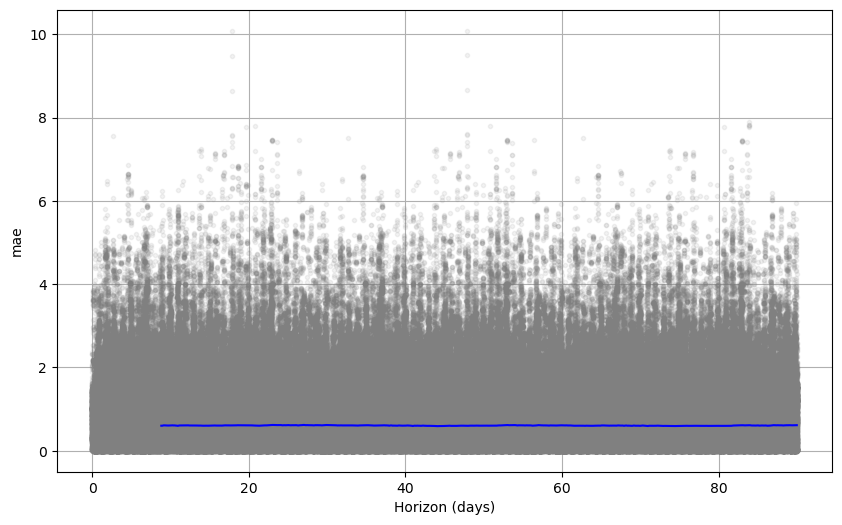

In [36]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

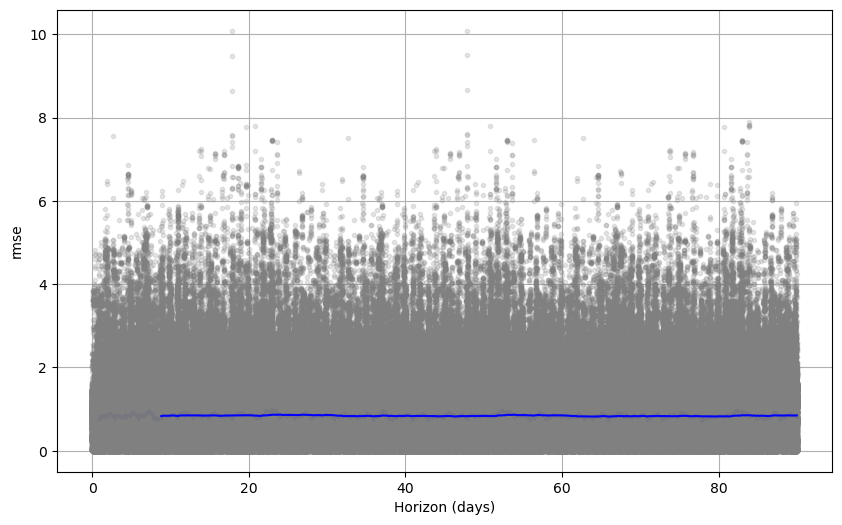

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=.01,
                             ax=ax)
plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=.1,
                             ax=ax)
plt.show()